In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy.misc import derivative
from scipy.optimize import fsolve
from scipy.optimize import minimize
N = norm.cdf
N2 = norm.sf

def PowerOptionBS(S, K, T, r, q, sigma, n):
    if T == 0:
        return np.maximum((S**n - K), 0)
    else:
        d1 = (np.log(S / (K ** (1 / n))) + (r - q + (n - 0.5) * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - n * sigma * np.sqrt(T)
        return (S ** n) * np.exp(((n - 1) * (r + (n * sigma ** 2) / 2) - n * q) * T) * N(d1) - K * np.exp(-r * T) * N(d2) 
 
    
def CallOptionBS(S, K, T, r, q, sigma):
    if T == 0.0:
        return np.maximum(S - K, 0)
    else:
        d1 = (np.log(S / K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * np.exp(-q * T) * N(d1) - K * np.exp(-r * T) * N(d2)

def upprob(st,s0,dt,r,q,sigma):
    k = np.log(st/s0) - (r-q-0.5*sigma**2)*dt
    return N2(k/(sigma*np.sqrt(dt)))
def downprob(st,s0,dt,r,q,sigma):
    k = np.log(st/s0) - (r-q-0.5*sigma**2)*dt
    return 1-N2(k/(sigma*np.sqrt(dt)))
def intprob(sa,sb,s0,dt,r,q,sigma):
    return downprob(sb,s0,dt,r,q,sigma) - downprob(sa,s0,dt,r,q,sigma)

In [2]:
def var(loss,s0,K,T,dt,r,q,sigma,n,hedge,prob):
    i = 0.3+np.floor(dt*250/60)*0.3
    smax = np.ceil(s0*(1+i))
    smin = np.floor(s0*(1-i))
    if smin<0:
        smin = s0*0.1
    SS = np.arange(smin,smax+1,1)
    B = PowerOptionBS(s0, K**n, T, r, q, sigma, n)
    PO = PowerOptionBS(SS, K**n, T-dt, r, q, sigma, n)
    Call = CallOptionBS(SS, K, T-dt, r, q, sigma)
    yToFind = loss
    yreduced = np.array(B-PO+hedge*(SS-s0)) + yToFind
    freduced = interpolate.UnivariateSpline(SS, yreduced, s=0)
    x = freduced.roots()
    dx = derivative(freduced, freduced.roots(), dx=1e-6)
    N = x.shape[0]
    if N==0:
        return 1
    if N%2==0:
        if dx[0]>0:
            na = int(N/2)
            p = downprob(x[0],s0,dt,r,q,sigma)-prob
            for i in range(0,na-1):
                p+= intprob(x[2*i-1],x[2*i],s0,dt,r,q,sigma)
            return p+upprob(x[N-1],s0,dt,r,q,sigma)
        else:
            na = int(N/2)
            p = -prob
            for i in range(0,na):
                p+= intprob(x[2*i],x[2*i+1],s0,dt,r,q,sigma)
            return p
    else:
        if dx[0]>0:
            na = int((N+1)/2)
            p = downprob(x[0],s0,dt,r,q,sigma)-prob
            for i in range(0,na-1):
                p+= intprob(x[2*i-1],x[2*i],s0,dt,r,q,sigma)
            return p
        else:
            na = int((N+1)/2)
            p = upprob(x[-1],s0,dt,r,q,sigma)-prob
            for i in range(0,na-1):
                p+= intprob(x[2*i],x[2*i+1],s0,dt,r,q,sigma)
            return p
        
def var2(loss,s0,K,T,dt,r,q,sigma,n,hedge,prob):
    x1 = hedge[0]
    x2 = hedge[1]
    i = 0.3+np.floor(dt*250/60)*0.3
    smax = np.ceil(s0*(1+i))
    smin = np.floor(s0*(1-i))
    if smin<0:
        smin = s0*0.1
    SS = np.arange(smin,smax+1,1)
    CC = CallOptionBS(s0, K, T, r, q, sigma)
    B = PowerOptionBS(s0, K**n, T, r, q, sigma, n)
    PO = PowerOptionBS(SS, K**n, T-dt, r, q, sigma, n)
    Call = CallOptionBS(SS, K, T-dt, r, q, sigma)
    yToFind = loss
    yreduced = np.array(B-PO+x1*(SS-s0)+x2*(Call-CC)) + yToFind
    freduced = interpolate.UnivariateSpline(SS, yreduced, s=0)
    x = freduced.roots()
    dx = derivative(freduced, freduced.roots(), dx=1e-6)
    N = x.shape[0]
    if N==0:
        return 1
    if N%2==0:
        if dx[0]>0:
            na = int(N/2)
            p = downprob(x[0],s0,dt,r,q,sigma)-prob
            for i in range(0,na-1):
                p+= intprob(x[2*i-1],x[2*i],s0,dt,r,q,sigma)
            return p+upprob(x[N-1],s0,dt,r,q,sigma)
        else:
            na = int(N/2)
            p = -prob
            for i in range(0,na):
                p+= intprob(x[2*i],x[2*i+1],s0,dt,r,q,sigma)
            return p
    else:
        if dx[0]>0:
            na = int((N+1)/2)
            p = downprob(x[0],s0,dt,r,q,sigma)-prob
            for i in range(0,na-1):
                p+= intprob(x[2*i-1],x[2*i],s0,dt,r,q,sigma)
            return p
        else:
            na = int((N+1)/2)
            p = upprob(x[-1],s0,dt,r,q,sigma)-prob
            for i in range(0,na-1):
                p+= intprob(x[2*i],x[2*i+1],s0,dt,r,q,sigma)
            return p

def var4(loss,s0,K,T,dt,r,q,sigma,n,hedge,prob):
    x1 = hedge[0]
    x2 = hedge[1]
    x3 = hedge[2]
    x4 = hedge[3]
    i = 0.3+np.floor(dt*250/60)*0.3
    smax = np.ceil(s0*(1+i))
    smin = np.floor(s0*(1-i))
    if smin<0:
        smin = s0*0.1
    SS = np.arange(smin,smax+1,1)
    CC1 = CallOptionBS(s0, K, T, r, q, sigma)
    CC2 = CallOptionBS(s0, 0.5*K, T, r, q, sigma)
    CC3 = CallOptionBS(s0, 2*K, T, r, q, sigma)
    B = PowerOptionBS(s0, K**n, T, r, q, sigma, n)
    PO = PowerOptionBS(SS, K**n, T-dt, r, q, sigma, n)
    Call1 = CallOptionBS(SS, K, T-dt, r, q, sigma)
    Call2 = CallOptionBS(SS, 0.5*K, T-dt, r, q, sigma)
    Call3 = CallOptionBS(SS, 2*K, T-dt, r, q, sigma)
    yToFind = loss
    yreduced = np.array(B-PO+x1*(SS-s0)+x2*(Call1-CC1)+x3*(Call2-CC2)+x4*(Call3-CC3)) + yToFind
    freduced = interpolate.UnivariateSpline(SS, yreduced, s=0)
    x = freduced.roots()
    dx = derivative(freduced, freduced.roots(), dx=1e-6)
    N = x.shape[0]
    if N==0:
        return 1
    if N%2==0:
        if dx[0]>0:
            na = int(N/2)
            p = downprob(x[0],s0,dt,r,q,sigma)-prob
            for i in range(0,na-1):
                p+= intprob(x[2*i-1],x[2*i],s0,dt,r,q,sigma)
            return p+upprob(x[N-1],s0,dt,r,q,sigma)
        else:
            na = int(N/2)
            p = -prob
            for i in range(0,na):
                p+= intprob(x[2*i],x[2*i+1],s0,dt,r,q,sigma)
            return p
    else:
        if dx[0]>0:
            na = int((N+1)/2)
            p = downprob(x[0],s0,dt,r,q,sigma)-prob
            for i in range(0,na-1):
                p+= intprob(x[2*i-1],x[2*i],s0,dt,r,q,sigma)
            return p
        else:
            na = int((N+1)/2)
            p = upprob(x[-1],s0,dt,r,q,sigma)-prob
            for i in range(0,na-1):
                p+= intprob(x[2*i],x[2*i+1],s0,dt,r,q,sigma)
            return p

In [3]:
s0 = 100
q = 0
r = 0.02
sigma = 0.3
T = 1
dt = 1/250
days = 250
K = 100
n = 2
prob = 0.05
B = PowerOptionBS(s0, K, T, r, q, sigma, n)

In [4]:
def hedge_var(hedge,s0,K,T,dt,r,q,sigma,n,prob):
    
    root = fsolve(var,0, args=(s0,K,T,dt,r,q,sigma,n,hedge,prob))
    return float(root)
def optimal_hedge(s0,K,T,dt,r,q,sigma,n,prob):
    Optimum = minimize(hedge_var,100,args=(s0,K,T,dt,r,q,sigma,n,prob))
    return Optimum.x

def hedge_var2(hedge,s0,K,T,dt,r,q,sigma,n,prob):
    
    root = fsolve(var2,0, args=(s0,K,T,dt,r,q,sigma,n,hedge,prob))
    return float(root)
def optimal_hedge2(s0,K,T,dt,r,q,sigma,n,prob):
    Optimum = minimize(hedge_var2,[100,10],args=(s0,K,T,dt,r,q,sigma,n,prob))
    return Optimum.x
def hedge_var4(hedge,s0,K,T,dt,r,q,sigma,n,prob):
    
    root = fsolve(var4,0, args=(s0,K,T,dt,r,q,sigma,n,hedge,prob))
    return float(root)
def optimal_hedge4(s0,K,T,dt,r,q,sigma,n,prob):
    Optimum = minimize(hedge_var4,[100,10,10,10],args=(s0,K,T,dt,r,q,sigma,n,prob))
    return Optimum.x
def constraint(x,s0,K,T,dt,r,q,sigma,B):
    C = CallOptionBS(s0, K, T, r, q, sigma)
    return float(B-x[0]*s0-x[1]*C)
def balance_optimal_hedge2(s0,K,T,dt,r,q,sigma,n,prob,B):
    con = {'type': 'ineq', 'fun': constraint, 'args':(s0,K,T,dt,r,q,sigma,B)}
    Optimum = minimize(hedge_var2,[100,10],args=(s0,K,T,dt,r,q,sigma,n,prob),constraints = con)
    return Optimum.x
def long_optimal_hedge2(s0,K,T,dt,r,q,sigma,n,prob,B):
    con = {'type': 'ineq', 'fun': constraint, 'args':(s0,K,T,dt,r,q,sigma,B)}
    C = CallOptionBS(s0, K, T, r, q, sigma)
    bnds =((0,B/s0),(0,B/C))
    Optimum = minimize(hedge_var2,[100,10],args=(s0,K,T,dt,r,q,sigma,n,prob),bounds = bnds,constraints = con)
    return Optimum.x

In [5]:
optimal_hedge(s0,100,T,dt,r,q,sigma,2,0.05)

array([155.64544657])

In [6]:
optimal_hedge2(s0,100,T,dt,r,q,sigma,2,0.05)

array([-32.68300731, 321.47173432])

In [7]:
x1 = optimal_hedge2(s0,K,T,dt,r,q,sigma,n,0.05)
print(x1)
print(hedge_var2(x1,s0,K,T,dt,r,q,sigma,n,prob))

[-32.68300731 321.47173432]
0.2511551606148924


In [8]:
x2 = balance_optimal_hedge2(s0,K,T,dt,r,q,sigma,n,0.05,B)
print(x2)
print(hedge_var2(x2,s0,K,T,dt,r,q,sigma,n,prob))

[-43.52377006 339.86378206]
0.738163406070529


In [9]:
x3 = long_optimal_hedge2(s0,K,T,dt,r,q,sigma,n,0.05,B)
print(x3)
print(hedge_var2(x3,s0,K,T,dt,r,q,sigma,n,prob))

[1.01119488e-12 2.65719624e+02]
3.5571130361802483


In [10]:
SS = np.arange(70,131,1)
CC1 = CallOptionBS(s0, 100, T, r, q, sigma)
CC2 = CallOptionBS(s0, 50, T, r, q, sigma)
CC3 = CallOptionBS(s0, 200, T, r, q, sigma)
B = PowerOptionBS(s0, 10000, T, r, q, sigma, 2)
PO = PowerOptionBS(SS, 10000, T-dt, r, q, sigma, 2)
Call1 = CallOptionBS(SS, 100, T-dt, r, q, sigma)
Call2 = CallOptionBS(SS, 50, T-dt, r, q, sigma)
Call3 = CallOptionBS(SS, 200, T-dt, r, q, sigma)

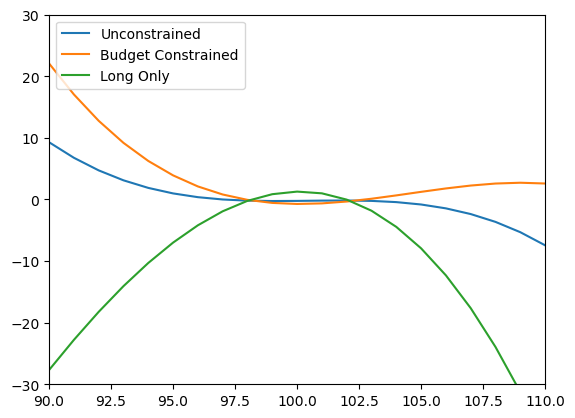

In [11]:
plt.plot(SS,B-PO+x1[0]*(SS-s0)+x1[1]*(Call1-CC1),label = "Unconstrained")
plt.plot(SS,B-PO+x2[0]*(SS-s0)+x2[1]*(Call1-CC1),label = "Budget Constrained")
plt.plot(SS,B-PO+x3[0]*(SS-s0)+x3[1]*(Call1-CC1),label = "Long Only")
plt.xlim(90,110)
plt.ylim(-30,30)
plt.legend(loc = "upper left")
plt.show()